**sklearn08_1_利用朴素贝叶斯模型识别垃圾短信**
**案例描述：**
> 本案例为《机器学习实践》课程第八章课件的配套代码，数据集中包含垃圾短信和正常短信两种文本数据，共5572条。本案例将介绍sklearn中文本抽取的方法，即由抽取出的数字特征建立朴素贝叶斯模型来识别垃圾短信。

**数据集：**
> 该数据集包含短信的文本信息和是否为垃圾短信的标签。<br> 
>> 非垃圾短信标记为ham, 垃圾短信标记为spam<br>

>本地路径：txt_path = "./dataSets/data_chap8/SMSSpamCollection" （以Tab分割）<br>
数据下载：http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection


**理论：**
>**特征工程主要包含以下三个方面：**
>> （1）特征提取/抽取：将文本或图像等数据转换为可用于机器学习的数字特征   <br>
（2）特征选择：从全部数据特征中选取一个特征子集     <br>
（3）特征构建：从原始特征中人工构建新的特征    <br>

> 这里以文本特征抽取为例(现在图像处理倾向于使用深度学习方法): <br>
> 两类传统方法：
>> (1) 词袋法(CountVectorizer)：只考虑词汇在文本中出现的频率   <br>
>> (2) 词频-逆文本频率(TfidfVectorizer)：除了考量某词汇在文本中出现的频率，还关注包含这个词汇的文本数量；适合文本条目多的情况  <br>
>> ![](./imgs/chap08/fig08_01.png)
 ![](./imgs/chap08/fig08_02.png)
 ![](./imgs/chap08/fig08_03.png)
 ![](./imgs/chap08/fig08_04.png)



> sklearn中的类`feature_extraction.text`：
>> |类	|说明|
|---:|---:|
|feature_extraction.text.CountVectorizer	|将文本转换为词袋模型|
|feature_extraction.text.TfidfVectorizer	|将文本转换为TF-IDF矩阵|

>> |通用方法	|说明|
|---:|---:|
|fit(X, y)	|学习文本的向量表示|
|transform(X)	|转化为向量表示的矩阵|
|fit_transform(X, y)	|先学习再转换为向量表示|
|get_feature_names()	|查看所有文本的词汇（列表对象）|


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False 
%matplotlib inline

# 数据预处理

In [4]:
## 导入数据
txt_path = "./dataSets/data_chap8/SMSSpamCollection.txt"
message = pd.read_csv(txt_path,sep="\t",encoding='unicode_escape')
message.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


★知识点：关于`encoding='unicode_escape',参考：`https://www.cnblogs.com/my_captain/p/9092644.html

In [5]:
## 分离X与y
X = message["text"].copy()
y = message["type"].copy()

In [7]:
##  目标y数值编码,'ham':0, 'spam':1
y = y.map({'ham':0, 'spam':1})

In [8]:
# 查看目标y中的类别
y.unique()

array([0, 1], dtype=int64)

In [9]:
## split X： 分割数据集,验证集占训练集20%，固定随机种子（random_state=10)
from sklearn.model_selection  import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [10]:
X_train.shape,X_test.shape

((4457,), (1115,))

# 文本特征抽取

## `CountVectorizer`抽取及建模分析
> 使用词袋模型抽取文本特征

> `CountVectorizer`:
>>|常用参数	|说明|
|---:|---:|
|stop_words	|设置停用词，默认为None（没有），可设置为“english”或list（自行给定）|
|min_df	|设定阈值，构建词汇表时，忽略文档频率严格低于这个阈值的词汇，默认为1|
|binary	|默认为False，True表示向量表示中所有非零项标记为1|

>> 参数说明：
>>> ●stop_words: 可设为string {'english'}，list或None（默认）；
>>>>设为english将使用内置的英语停用词； <br>
设为list可自定义停用词； <br>
设为None不使用停用词；    <br>
设为None且参数max_df∈[0.7, 1.0)时将自动根据当前的语料库建立停用词表

>>>●max_df：float in range [ 0.0，1.0 ]或int，default（默认）= 1.0；
>>>>作为阈值，构造词汇表时，如果某词的文档频率大于max_df，则这个词不会被当作关键词；   <br>
为浮点值，则表示词出现的次数与文档数的百分比；    <br>
为整数，则表示词出现的次数；     <br>
如果给定了参数vocabulary，则此参数无效   <br>

>>>●min_df：float in range [ 0.0，1.0 ]或int，default = 1；
>>>> 作为阈值，构建词汇表时忽略文档频率低于min_df的词语；   <br>
与max_df的作用类似    <br>


>>|属性列表	|说明|
|---:|---:|
|vocabulary_	|返回词汇表（字典对象）|
|stop_words_	|返回停用词表|

>> 属性说明：
>>>●vocabulary_：字典类型，key为关键词，value是特征索引


> 官方文档：https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html



### 特征抽取

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

#采用CountVectorizer提取特征向量，并去除停用词
count_vec = CountVectorizer(stop_words='english')
count_vec.fit(X_train)   # 学习文本的向量表示
x_count_train = count_vec.transform(X_train)   # 将X_train转化为向量表示的矩阵
x_count_test = count_vec.transform(X_test)   # 将X_test转化为向量表示的矩阵

In [13]:
# 查看向量表示矩阵
x_count_train

<4457x7494 sparse matrix of type '<class 'numpy.int64'>'
	with 35055 stored elements in Compressed Sparse Row format>

解析：训练数据的词袋表示，共7494个特征

In [14]:
# 输出向量表示矩阵(压缩矩阵)
print(x_count_train)

  (0, 5245)	1
  (1, 3135)	1
  (1, 3231)	1
  (1, 3278)	1
  (1, 4772)	1
  (1, 5860)	1
  (1, 7303)	1
  (2, 4644)	1
  (2, 6682)	1
  (2, 7203)	1
  (2, 7361)	1
  (3, 2112)	1
  (3, 2124)	1
  (3, 4103)	1
  (3, 4625)	1
  (3, 6721)	1
  (4, 648)	1
  (4, 2109)	1
  (4, 2276)	1
  (4, 2687)	1
  (4, 2917)	1
  (4, 3752)	1
  (4, 4103)	1
  (4, 4196)	1
  (4, 4290)	1
  :	:
  (4454, 1001)	1
  (4454, 1994)	1
  (4454, 2416)	1
  (4454, 2718)	1
  (4454, 2909)	1
  (4454, 3005)	1
  (4454, 3183)	1
  (4454, 3848)	1
  (4454, 3957)	1
  (4454, 3988)	2
  (4454, 4033)	1
  (4454, 4075)	1
  (4454, 4233)	1
  (4454, 4267)	1
  (4454, 5261)	1
  (4454, 5748)	1
  (4454, 6635)	1
  (4454, 6640)	1
  (4455, 1563)	1
  (4455, 1636)	1
  (4455, 2775)	1
  (4455, 2797)	1
  (4456, 3237)	1
  (4456, 4615)	1
  (4456, 7432)	1


解析：`(0, 5245)	1`,表示：第0个列表(样本)，词典中索引为5245的元素(特征)， 词频为1。 那么index为5245的这个元素是哪个词呢？继续。。

In [15]:
# 转化为非压缩矩阵: 结果会是一个稀疏矩阵
print(x_count_train.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
# 查看每个词在所有文档中的词频：即纵向求和
print(x_count_train.toarray().sum(axis=0))

[ 7 26  2 ...  1  1 94]


解析：第一个特征词在整个X_Train中出现了7次，第二个特征词出现了26次。。。。。第7494个特征词出现了94次

In [20]:
## 查看词汇表（K：V）：K表示词汇，V表示该词汇在词袋中的位置index
count_vec.vocabulary_

{'princess': 5245,
 'great': 3135,
 'hear': 3278,
 'settling': 5860,
 'happenin': 3231,
 'wit': 7303,
 'ola': 4772,
 'wot': 7361,
 'wed': 7203,
 'nite': 4644,
 'til': 6682,
 'nice': 4625,
 'day': 2112,
 'today': 6721,
 'love': 4103,
 'dearly': 2124,
 'talk': 6499,
 'sexy': 5865,
 'make': 4196,
 'new': 4615,
 'friends': 2917,
 'fall': 2687,
 'worlds': 7352,
 'discreet': 2276,
 'text': 6583,
 'dating': 2109,
 'service': 5851,
 'just': 3752,
 'vip': 7072,
 '83110': 648,
 'meet': 4290,
 'money': 4431,
 'aint': 859,
 'thing': 6630,
 'sha': 5870,
 'havent': 3258,
 'collected': 1823,
 'dough': 2359,
 'pls': 5093,
 'let': 3962,
 'know': 3837,
 'place': 5065,
 'sent': 5840,
 'control': 1923,
 'number': 4704,
 'came': 1563,
 'hostel': 3402,
 'oh': 4760,
 'forwarded': 2881,
 'message': 4321,
 'thought': 6649,
 'send': 5830,
 'neva': 4610,
 'grumble': 3158,
 'sad': 5695,
 'lor': 4083,
 'hee': 3290,
 'buy': 1518,
 'tmr': 6710,
 'aft': 833,
 'lunch': 4135,
 'meetin': 4291,
 'fr': 2887,
 'lei': 3950,

解释：所有词汇存储在一个字典对象中，字典中的键是词汇，值是该词汇的索引

In [21]:
## 查看词汇表前10个词word及在词袋中的索引index
for word,index in list(count_vec.vocabulary_.items())[:10]:
    print('{}:{}'.format(word,index))
    

princess:5245
great:3135
hear:3278
settling:5860
happenin:3231
wit:7303
ola:4772
wot:7361
wed:7203
nite:4644


In [22]:
# 查看索引所对应的词汇，例如：查看第[5245]索引对应的词汇特征
print(count_vec.get_feature_names()[5245])

princess


### 建模及评价
> 建立并训练多项式贝叶斯模型

In [23]:
## 建立并训练多项式贝叶斯模型
from sklearn.naive_bayes import MultinomialNB
mnb_count = MultinomialNB()
mnb_count.fit(x_count_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
## 模型预测
mnb_count_y_pred = mnb_count.predict(x_count_test)

In [18]:
## 模型评价
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("预测正确率：",accuracy_score(y_true=_________,y_pred=______________))
print("分类报告:\n",classification_report(y_true=y_test,y_pred=mnb_count_y_pred))

预测正确率： 0.979372197309417
分类报告:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       972
           1       0.95      0.89      0.92       143

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Text(0.5, 1.0, '混淆矩阵热力图')

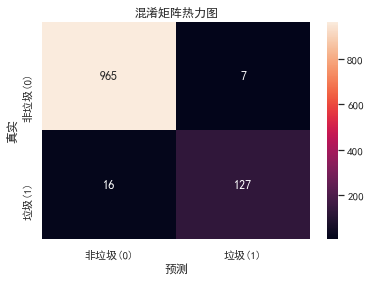

In [19]:
## 中文显示
sns.set(font="SimHei")

ax = sns.heatmap(confusion_matrix(_________,_________),
                 annot=True, fmt='d',
                 xticklabels=["非垃圾(0)","垃圾(1)"],
                 yticklabels=["非垃圾(0)","垃圾(1)"]
                )

ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

## `TfidfVectorizer`抽取特征及建模分析
> 使用TF-IDF抽取文本特征

> `TfidfVectorizer`:
>>|常用参数	|说明|
|---:|---:|
|stop_words	|设置停用词，默认为None（没有），可设置为“english”或list（自行给定）|
|min_df	|设定阈值，构建词汇表时，忽略文档频率严格低于这个阈值的词汇，默认为1|
|binary	|默认为False，True表示向量表示中所有非零项标记为1|
|smooth_idf	|默认为True，向逆文档频率添加一个平滑项，防止其计算的值为0|


>>|属性列表	|说明|
|---:|---:|
|vocabulary_	|返回词汇表（字典对象）|
|stop_words_	|返回停用词表|
|idf_	|idf值|


### 特征抽取

In [20]:
# 采用TfidfVectorizer提取文本特征向量，使用英文停用词
from __________________ import TfidfVectorizer

## 实例化TFIDF
tfidf_vec = TfidfVectorizer(stop_words="english")

# 使用训练文本学习文本的向量表示
tfidf_vec.fit(X_train)


#（X_train）转化为向量表示的矩阵
x_tfidf_train = tfidf_vec._________

# (X_test)转化为向量表示的矩阵
x_tfidf_test = tfidf_vec._________
    

In [21]:
## 查看词汇表前10个词及在词带中的索引
for word,index in list(tfidf_vec.vocabulary_.items())[:10]:
    print('{}:{}'.format(word,index))

princess:5245
great:3135
hear:3278
settling:5860
happenin:3231
wit:7303
ola:4772
wot:7361
wed:7203
nite:4644


### 建模及评价

In [22]:
##  建立并训练多项式贝叶斯模型
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(_________,_________)

##  模型预测
mnb_tfidf_y_pred = mnb_tfidf.predict(_________)

In [23]:
## 模型评价
print("预测正确率：",accuracy_score(y_test,mnb_tfidf_y_pred))
print("分类报告:\n",classification_report(y_test,mnb_tfidf_y_pred))

预测正确率： 0.9632286995515695
分类报告:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       972
           1       1.00      0.71      0.83       143

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



Text(0.5, 1.0, '混淆矩阵热力图')

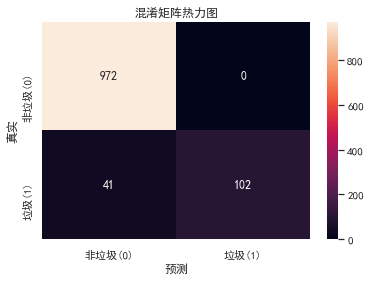

In [24]:
## 中文显示
sns.set(font="SimHei")

ax = sns.heatmap(confusion_matrix(y_test,mnb_tfidf_y_pred),
                 annot=True, fmt='d',
                 xticklabels=["非垃圾(0)","垃圾(1)"],
                 yticklabels=["非垃圾(0)","垃圾(1)"]
                )

ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

# 小结
> 文本特征抽取
>> (1) 词袋法(CountVectorizer)：只考虑词汇在文本中出现的频率    <br>
(2) 词频-逆文本频率(TfidfVectorizer)：除了考量某词汇在文本中出现的频率，还关注包含这个词汇的文本数量；适合文本条目多的情况